# Copy instead of modifying to preserve attack parameters

In [20]:
AGENT_NAME = 'Models/ATLA/PPO agent 100 alts over 0+500 1-17-21.zip'
ADVERSARY = 'Models/Adversary/default_adversary_PPO_citylearn_challenge_2022_phase_2_Building_6_20_bins_default_rwd_480.zip'
DATASET_NAME = 'citylearn_challenge_2022_phase_2' #only action is electrical storage
SAVE_DIR = 'PPO agent 100 alts over 0+500 1-17-21 results/5 run avg untargeted mybb' + '/'
RUNS = 5
TRIAL = 1

In [21]:
from stable_baselines3 import PPO

from citylearn.data import DataSet

from KBMproject.mybb import BrendelBethgeAttack as BBA

import pandas as pd
import numpy as np

import KBMproject.utilities as utils

from joblib import Parallel, delayed
import json

%matplotlib inline

In [22]:
schema = DataSet.get_schema(DATASET_NAME)

Define RL agent

In [23]:
agents = []
for _ in range (RUNS):
    agents.append(PPO.load(path=AGENT_NAME))

In [24]:
adversaries = []
for _ in range (RUNS):
    adversaries.append(PPO.load(path=ADVERSARY))

In [25]:
envs = []
for _ in range (RUNS):
    envs.append(utils.make_discrete_env(schema=schema,  
                            action_bins=agents[0].action_space[0].n,
                            seed=42))

In [26]:
cols = utils.make_discrete_env(schema=schema,  
                            action_bins=agents[0].action_space[0].n,
                            seed=42).observation_names

In [27]:
observation_masks = np.ones(agents[0].observation_space.shape)
observation_masks[0:6] = 0 #mask time features
print('masked features:')
cols[0][0:6]

masked features:


['month_cos',
 'month_sin',
 'day_type_cos',
 'day_type_sin',
 'hour_cos',
 'hour_sin']

In [30]:
ATK_parameters = kwargs = dict(
    norm=np.inf,
    targeted=True, #default false
    overshoot= 1.1,
    steps=1000,
    lr=1e-3,
    lr_decay=0.5,
    lr_num_decay=20,
    momentum=0.8,
    binary_search_steps=10,
    init_size=1_000_000, #default 100, finds sample matching the target class through iterative random search
    batch_size=1000, 
)
attacks = []
for run in range(RUNS):
    attacks.append(utils.define_attack(agents[run], BBA, ART_kwargs=ATK_parameters))

In [31]:
%%time


kwargs = dict(
    #ART_atk=attack,
    #ART_atk_kwargs=ATK_parameters,
    time_steps=None,
    mask=observation_masks,
)
func = utils.eval_targeted_attack

results = Parallel(n_jobs=RUNS, verbose=10, prefer='threads')(delayed(
    func)(agent, adversary, env, attack, **kwargs) for agent, adversary, env, attack in zip(agents, adversaries, envs, attacks)) 


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.








  0%|          | 0/8759 [00:00<?, ?it/s]











  0%|          | 1/8759 [00:42<102:22:33, 42.08s/it, ASR=1]











  0%|          | 2/8759 [00:56<62:19:11, 25.62s/it, ASR=1] 











  0%|          | 3/8759 [01:11<50:28:39, 20.75s/it, ASR=1]











  0%|          | 4/8759 [01:25<44:27:04, 18.28s/it, ASR=1]











  0%|          | 5/8759 [01:40<41:30:03, 17.07s/it, ASR=1]















  0%|          | 6/8759 [01:55<39:31:15, 16.25s/it, ASR=1]













  0%|          | 7/8759 [02:10<38:25:07, 15.80s/it, ASR=1]











  0%|          | 8/8759 [02:24<37:29:49, 15.43s/it, ASR=1]











  0%|          | 9/8759 [02:39<36:57:31, 15.21s/it, ASR=1]















  0%|          | 10/8759 [02:54<36:42:40, 15.11s/it, ASR=1]

















  0%|          | 11/8759 [03:08<36:23:28, 14.98s/it, ASR=1]











  0%|          | 12/8759 [03:24<36:40:18, 15.09s/it, ASR=1]













  0%|          | 13/8759 [03:39<36:21:45, 14.97s/it, ASR=1]











  0%|    

CPU times: total: 3d 11h 14min 54s
Wall time: 1d 11h 13min 22s


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 2113.4min finished


In [32]:
with open(SAVE_DIR+'attack parameters.json', 'w') as f:
    json.dump(ATK_parameters, f)

Results is a list of tupples for each run, of the format(KPIs, observations, perturbed observations, epsilons)

In [33]:
for run in range(RUNS):
        # np.savetxt(f'run {run} obs {TRIAL}.csv', results[run][1], delimiter=",")
        # np.savetxt(f'run {run} adv_obs {TRIAL}.csv', results[run][2], delimiter=",")
    pd.DataFrame(results[run][1],columns=cols,).to_csv(SAVE_DIR+f'run {run} obs {TRIAL}.csv',)
    pd.DataFrame(results[run][2],columns=cols,).to_csv(SAVE_DIR+f'run {run} adv obs {TRIAL}.csv')

In [43]:
for run in range(RUNS):
    np.savetxt(SAVE_DIR+f'run {run} actions {TRIAL}.csv', results[run][3], delimiter=",")
    np.savetxt(SAVE_DIR+f'run {run} targets {TRIAL}.csv', results[run][4], delimiter=",")

In [41]:
ASRs = [results[i][5] for i in range(len(results))]

In [45]:
np.savetxt(SAVE_DIR+f'ASRs {TRIAL}.csv', ASRs, delimiter=",")

In [34]:
kpis = [results[i][0] for i in range(len(results))]
df_kpis = pd.concat(kpis, axis='columns',keys=range(RUNS))

In [35]:
df_kpis[['mean', 'std', 'variance']] = df_kpis.agg(['mean','std', 'var'], axis='columns')

In [36]:
df_kpis.to_csv(SAVE_DIR+f'{RUNS} run KPIs {TRIAL}.csv')

In [37]:
df_kpis

,0,1,2,3,4,mean,std,variance
cost_function,,,,,,,,
annual_peak_average,1.727378,1.727378,1.727378,1.727378,1.727378,1.727378,2.482534e-16,6.162976e-32
carbon_emissions_total,3.079257,3.078936,3.081068,3.079184,3.081705,3.080030,1.264205e-03,1.598214e-06
cost_total,2.828683,2.824173,2.831263,2.829090,2.832378,2.829118,3.157048e-03,9.966952e-06
daily_one_minus_load_factor_average,0.963319,0.963203,0.963260,0.962943,0.963260,0.963197,1.477206e-04,2.182137e-08
daily_peak_average,2.946906,2.946312,2.946915,2.941327,2.946915,2.945675,2.444449e-03,5.975331e-06
electricity_consumption_total,3.123485,3.123293,3.125872,3.123767,3.126319,3.124547,1.432322e-03,2.051545e-06
monthly_one_minus_load_factor_average,1.004375,1.004351,1.004240,1.003493,1.004342,1.004160,3.764298e-04,1.416994e-07
ramping_average,16.375606,16.377340,16.391423,16.378152,16.392413,16.382987,8.212133e-03,6.743913e-05
zero_net_energy,1.698360,1.698745,1.698931,1.699098,1.698915,1.698810,2.806770e-04,7.877956e-08


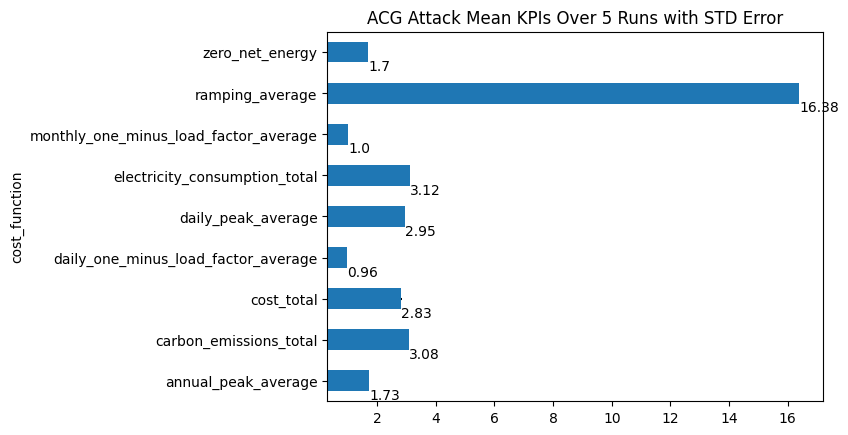

In [38]:
ax = df_kpis['mean'].plot.barh(xerr = df_kpis['std'], xlim=0.3, title='ACG Attack Mean KPIs Over 5 Runs with STD Error')
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width(), 
            i.get_y()-0.2,
            str(round((i.get_width()), 2)), 
            fontsize=10, 
            #color='dimgrey'
            )

In [39]:
eps = [pd.Series(results[i][3]) for i in range(len(results))]
df_eps = pd.concat(eps, axis='columns',keys=range(RUNS))

ValueError: Data must be 1-dimensional

In [ ]:
df_eps.to_csv(SAVE_DIR+f'{RUNS} run epsilons {TRIAL}.csv')

In [ ]:
eps_value_counts = df_eps.apply(lambda col: col.value_counts(), axis='rows')

Calculate the ASRs (notna returns a series of 0 or 1 for True or False, to the mean is the proportion)

In [ ]:
ASRs = df_eps.notna().mean()
ASRs.name = 'ASR'
eps_value_counts = eps_value_counts.append(ASRs)
eps_value_counts[['mean', 'std', 'variance']] = eps_value_counts.agg(['mean','std', 'var'], axis='columns')

In [ ]:
eps_value_counts

,0,1,2,3,4,mean,std,variance
0.01,5238.000000,5232.000000,5232.000000,5210.000000,5241.000000,5230.600000,12.157302,1.478000e+02
0.03,3096.000000,3094.000000,3091.000000,3140.000000,3080.000000,3100.200000,23.091124,5.332000e+02
0.05,371.000000,375.000000,391.000000,357.000000,377.000000,374.200000,12.214745,1.492000e+02
0.07,50.000000,56.000000,39.000000,48.000000,55.000000,49.600000,6.804410,4.630000e+01
ASR,0.999543,0.999772,0.999315,0.999543,0.999315,0.999498,0.000191,3.649631e-08


<Axes: title={'center': 'Mean Epsilon Values of 5 runs'}, ylabel='mean'>

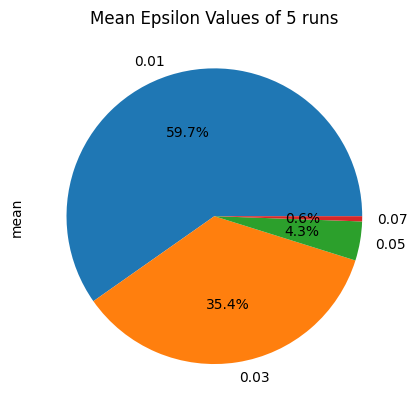

In [ ]:
eps_value_counts['mean'].iloc[:-1].plot.pie(autopct='%1.1f%%', title=f'Mean Epsilon Values of {RUNS} runs')